<a href="https://colab.research.google.com/github/ariahosseini/TradML/blob/main/ML_BandGap_Inorganic_Materials.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

### Libs

In [2]:
!pip install -q import_ipynb shap pymatgen scikit-learn-intelex

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 66.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 191.5/191.5 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 57.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.6/66.6 MB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 63.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 332.3/332.3 kB 21.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 561.4/561.4 kB 25.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.8/117.8 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 45.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 

In [3]:
from sklearnex import patch_sklearn

In [4]:
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [5]:
# utils
import os, sys, warnings, itertools
import shap
import random
import pickle
import import_ipynb
import pandas as pd
import numpy as np
# colab
from google.colab import drive
# lightgbm
import lightgbm as lgb
# xgboost
import xgboost as xgb
# sklearn
from sklearn.neighbors import KNeighborsRegressor
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import (StandardScaler, OneHotEncoder, FunctionTransformer)
from sklearn.base import (BaseEstimator, TransformerMixin)
from sklearn.compose import (ColumnTransformer, make_column_transformer)
from sklearn.pipeline import (Pipeline, make_pipeline)
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import (mean_absolute_error, mean_squared_error, r2_score)
from sklearn.model_selection import (train_test_split,
                                     GridSearchCV,
                                     cross_val_score,
                                     RandomizedSearchCV,
                                     KFold)
from sklearn.ensemble import (RandomForestClassifier,
                              RandomForestRegressor,
                              GradientBoostingClassifier,
                              GradientBoostingRegressor,
                              BaggingClassifier,
                              BaggingRegressor,
                              ExtraTreesClassifier,
                              ExtraTreesRegressor,
                              AdaBoostClassifier,
                              AdaBoostRegressor,
                              HistGradientBoostingClassifier,
                              HistGradientBoostingRegressor,
                              StackingClassifier,
                              StackingRegressor,
                              VotingClassifier)
# pymatgen
import pymatgen as mg
from pymatgen.core.composition import Composition
# vis
import seaborn as sns
import matplotlib.pyplot as plt

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


### Settings

In [6]:
warnings.filterwarnings('ignore')

In [7]:
# mount google drive
drive.mount("/content/drive")

Mounted at /content/drive


In [8]:
# working directory
working_dir = '/content/drive/MyDrive/Jupyter Notebooks/'
os.chdir(working_dir)

In [9]:
# module dir
module_path = os.path.abspath(os.path.join("./"))
if module_path not in sys.path:
    sys.path.append(module_path)

In [10]:
# load MachineLearningUtils module
from MachineLearningUtils import *

## Materials Encoder

In [11]:
class materials_encoder:
    def __init__(self, descriptor):
        """
        Initialize the VectorizeFormula class by loading the elemental properties data from a file.
        """

        self.element_df = descriptor.copy()
        self.element_df.set_index('Symbol', inplace=True)

        self.column_names = [f'{stat}_{prop}'
                             for stat in ['avg', 'diff', 'max', 'min']
                             for prop in self.element_df.columns]

    def get_features(self, formula):
        """
        Generate features based on the composition of the given chemical formula.

        Parameters:
        - formula: Chemical formula as a string (e.g., 'H2O')

        Returns:
        - A numpy array of computed features (average, difference, max, min properties).
          If an element is missing from the database, returns NaNs.
        """
        try:
            fractional_composition = self._get_fractional_composition(formula)
            if fractional_composition is None:
                return self._return_nan_features()

            avg_feature, diff_feature, max_feature, min_feature = self._compute_features(fractional_composition)

            features = np.concatenate([avg_feature, diff_feature, max_feature, min_feature])
            return features

        except Exception as e:
            print(f'Error processing formula {formula}: {str(e)}')
            return self._return_nan_features()

    def _get_fractional_composition(self, formula):
        """
        Parse the formula and return its fractional composition as a dictionary.
        Returns None if an element is missing in the database.
        """
        try:
            comp = Composition(formula)
            return comp.fractional_composition.as_dict()
        except Exception as e:
            print(f'Invalid formula or parsing error for {formula}: {str(e)}')
            return None

    def _compute_features(self, fractional_composition):
        """
        Compute average, difference, max, and min features for the given composition.
        """

        avg_feature = np.zeros(len(self.element_df.columns))
        diff_feature = np.zeros(len(self.element_df.columns))

        element_keys = list(fractional_composition.keys())

        for element in element_keys:
            if element not in self.element_df.index:
                print(f"Element '{element}' not found in the database.")
                return self._return_nan_features()

        for element, fraction in fractional_composition.items():
            avg_feature += self.element_df.loc[element].values * fraction

        max_feature = self.element_df.loc[element_keys].max().values
        min_feature = self.element_df.loc[element_keys].min().values
        diff_feature = max_feature - min_feature

        return avg_feature, diff_feature, max_feature, min_feature

    def _return_nan_features(self):
        """
        Return a numpy array filled with NaNs for unsupported or invalid formulas.
        """
        num_features = len(self.element_df.columns) * 4
        return np.full(num_features, np.nan)

## Process Data

### Load Data

In [12]:
data_dir = "Inputs/Bandgap_Inorganic"

In [13]:
df = pd.read_excel(os.path.join(data_dir, 'dataset.xlsx'))
descriptor = pd.read_excel(os.path.join(data_dir, 'descriptor.xlsx'))

### Understand Data

In [14]:
df.set_index('Composition', inplace=True)

In [15]:
encoder = materials_encoder(descriptor)

features = []
for formula in df.index:
    feature = encoder.get_features(formula)
    features.append(feature)

desc = pd.DataFrame(features, columns=encoder.column_names)
desc.index = df.index

In [16]:
reduce_memory_usage(df=desc, category=True)

Memory usage of dataframe is 5.138336 MB!
Memory usage after optimization is 1.312714 MB!
Decreased by 74.5%


In [17]:
summarize_columns(desc)

col_name   dtypes  missing  missing_percent  \
0                    avg_Atomic number  float16        0              0.0   
1                    avg_Atomic weight  float16        0              0.0   
2                    avg_Period number  float16        0              0.0   
3                     avg_Group number  float16        0              0.0   
4                    avg_Family number  float16        0              0.0   
..                                 ...      ...      ...              ...   
131        min_Heat of fusion (kJ/mol)  float16        0              0.0   
132  min_Heat of vaporization (kJ/mol)  float16        0              0.0   
133   min_Thermal conductivity (W/m•K)  float16        0              0.0   
134      min_Heat atomization (kJ/mol)  float16        0              0.0   
135           min_Cohesive energy (eV)  float16        0              0.0   

     uniques  first_value  second_value  third_value  
0       1713    50.562500     50.562500    50.531250  
1       2413   121.750000    121.687500   121.625000  
2        687     5.000000      5.000000     5.000000  
3        743    14.570312     14.570312    14.539062  
4        539     5.441406      5.464844     5.433594  
..       ...          ...           ...          ...  
131       74     3.263672      3.263672     3.263672  
132       74    52.562500     52.562500    52.562500  
133       76     2.349609      2.349609     2.349609  
134       69   112.000000    112.000000   112.000000  
135       75     1.160156      1.160156     1.160156  

[136 rows x 8 columns]

In [18]:
display_df(desc)

Dataframe:  
num_rows = 4,916 
num_cols = 136


avg_Atomic number  avg_Atomic weight  avg_Period number  \
Composition                                                                     
Ag0.1Cd0.8In2.1Te4             50.56250           121.7500                5.0   
Ag0.25Cd0.5In2.25Te4           50.56250           121.6875                5.0   
Ag0.2Cd0.75In2.1Te4            50.53125           121.6250                5.0   
Ag0.4Cd0.2In2.4Te4             50.56250           121.6250                5.0   
Ag0.4Cd0.5In2.2Te4             50.50000           121.4375                5.0   

                      avg_Group number  avg_Family number  \
Composition                                                 
Ag0.1Cd0.8In2.1Te4           14.570312           5.441406   
Ag0.25Cd0.5In2.25Te4         14.570312           5.464844   
Ag0.2Cd0.75In2.1Te4          14.539062           5.433594   
Ag0.4Cd0.2In2.4Te4           14.570312           5.484375   
Ag0.4Cd0.5In2.2Te4           14.507812           5.437500   

                      avg_L quantum number  avg_Mendeleev number  \
Composition                                                        
Ag0.1Cd0.8In2.1Te4                0.871582               82.8750   
Ag0.25Cd0.5In2.25Te4              0.893066               82.8750   
Ag0.2Cd0.75In2.1Te4               0.865234               82.6875   
Ag0.4Cd0.2In2.4Te4                0.914062               82.8750   
Ag0.4Cd0.5In2.2Te4                0.873047               82.5625   

                      avg_Atomic radius (Å)  avg_Covalent radius (Å)  \
Composition                                                            
Ag0.1Cd0.8In2.1Te4                 1.464844                 1.397461   
Ag0.25Cd0.5In2.25Te4               1.465820                 1.393555   
Ag0.2Cd0.75In2.1Te4                1.466797                 1.396484   
Ag0.4Cd0.2In2.4Te4                 1.466797                 1.389648   
Ag0.4Cd0.5In2.2Te4                 1.468750                 1.392578   

                      avg_Zunger radius (Å)  ...  min_Polarizability  \
Composition                                  ...                       
Ag0.1Cd0.8In2.1Te4                 1.856445  ...                 5.5   
Ag0.25Cd0.5In2.25Te4               1.856445  ...                 5.5   
Ag0.2Cd0.75In2.1Te4                1.861328  ...                 5.5   
Ag0.4Cd0.2In2.4Te4                 1.856445  ...                 5.5   
Ag0.4Cd0.5In2.2Te4                 1.866211  ...                 5.5   

                      min_Melting point (K)  min_Boiling point (K)  \
Composition                                                          
Ag0.1Cd0.8In2.1Te4                   429.75                 1038.0   
Ag0.25Cd0.5In2.25Te4                 429.75                 1038.0   
Ag0.2Cd0.75In2.1Te4                  429.75                 1038.0   
Ag0.4Cd0.2In2.4Te4                   429.75                 1038.0   
Ag0.4Cd0.5In2.2Te4                   429.75                 1038.0   

                      min_Density (g/mL)  min_Specific heat (J/g•K)  \
Composition                                                           
Ag0.1Cd0.8In2.1Te4              6.238281                   0.199951   
Ag0.25Cd0.5In2.25Te4            6.238281                   0.199951   
Ag0.2Cd0.75In2.1Te4             6.238281                   0.199951   
Ag0.4Cd0.2In2.4Te4              6.238281                   0.199951   
Ag0.4Cd0.5In2.2Te4              6.238281                   0.199951   

                      min_Heat of fusion (kJ/mol)  \
Composition                                         
Ag0.1Cd0.8In2.1Te4                       3.263672   
Ag0.25Cd0.5In2.25Te4                     3.263672   
Ag0.2Cd0.75In2.1Te4                      3.263672   
Ag0.4Cd0.2In2.4Te4                       3.263672   
Ag0.4Cd0.5In2.2Te4                       3.263672   

                      min_Heat of vaporization (kJ/mol)  \
Composition                                               
Ag0.1Cd0.8In2.1Te4                              52.5625   
A

Info:
<class 'pandas.core.frame.DataFrame'>
Index: 4916 entries, Ag0.1Cd0.8In2.1Te4 to ZrW2
Columns: 136 entries, avg_Atomic number to min_Cohesive energy (eV)
dtypes: float16(136)
memory usage: 1.3+ MB
Number of null data points:
avg_Mulliken EN    1
dtype: int64


In [19]:
cols = list(desc.columns)
numerical_cols = desc.select_dtypes(include=['float16', 'int16']).columns.tolist()
categorical_cols = [col for col in cols if col not in numerical_cols]

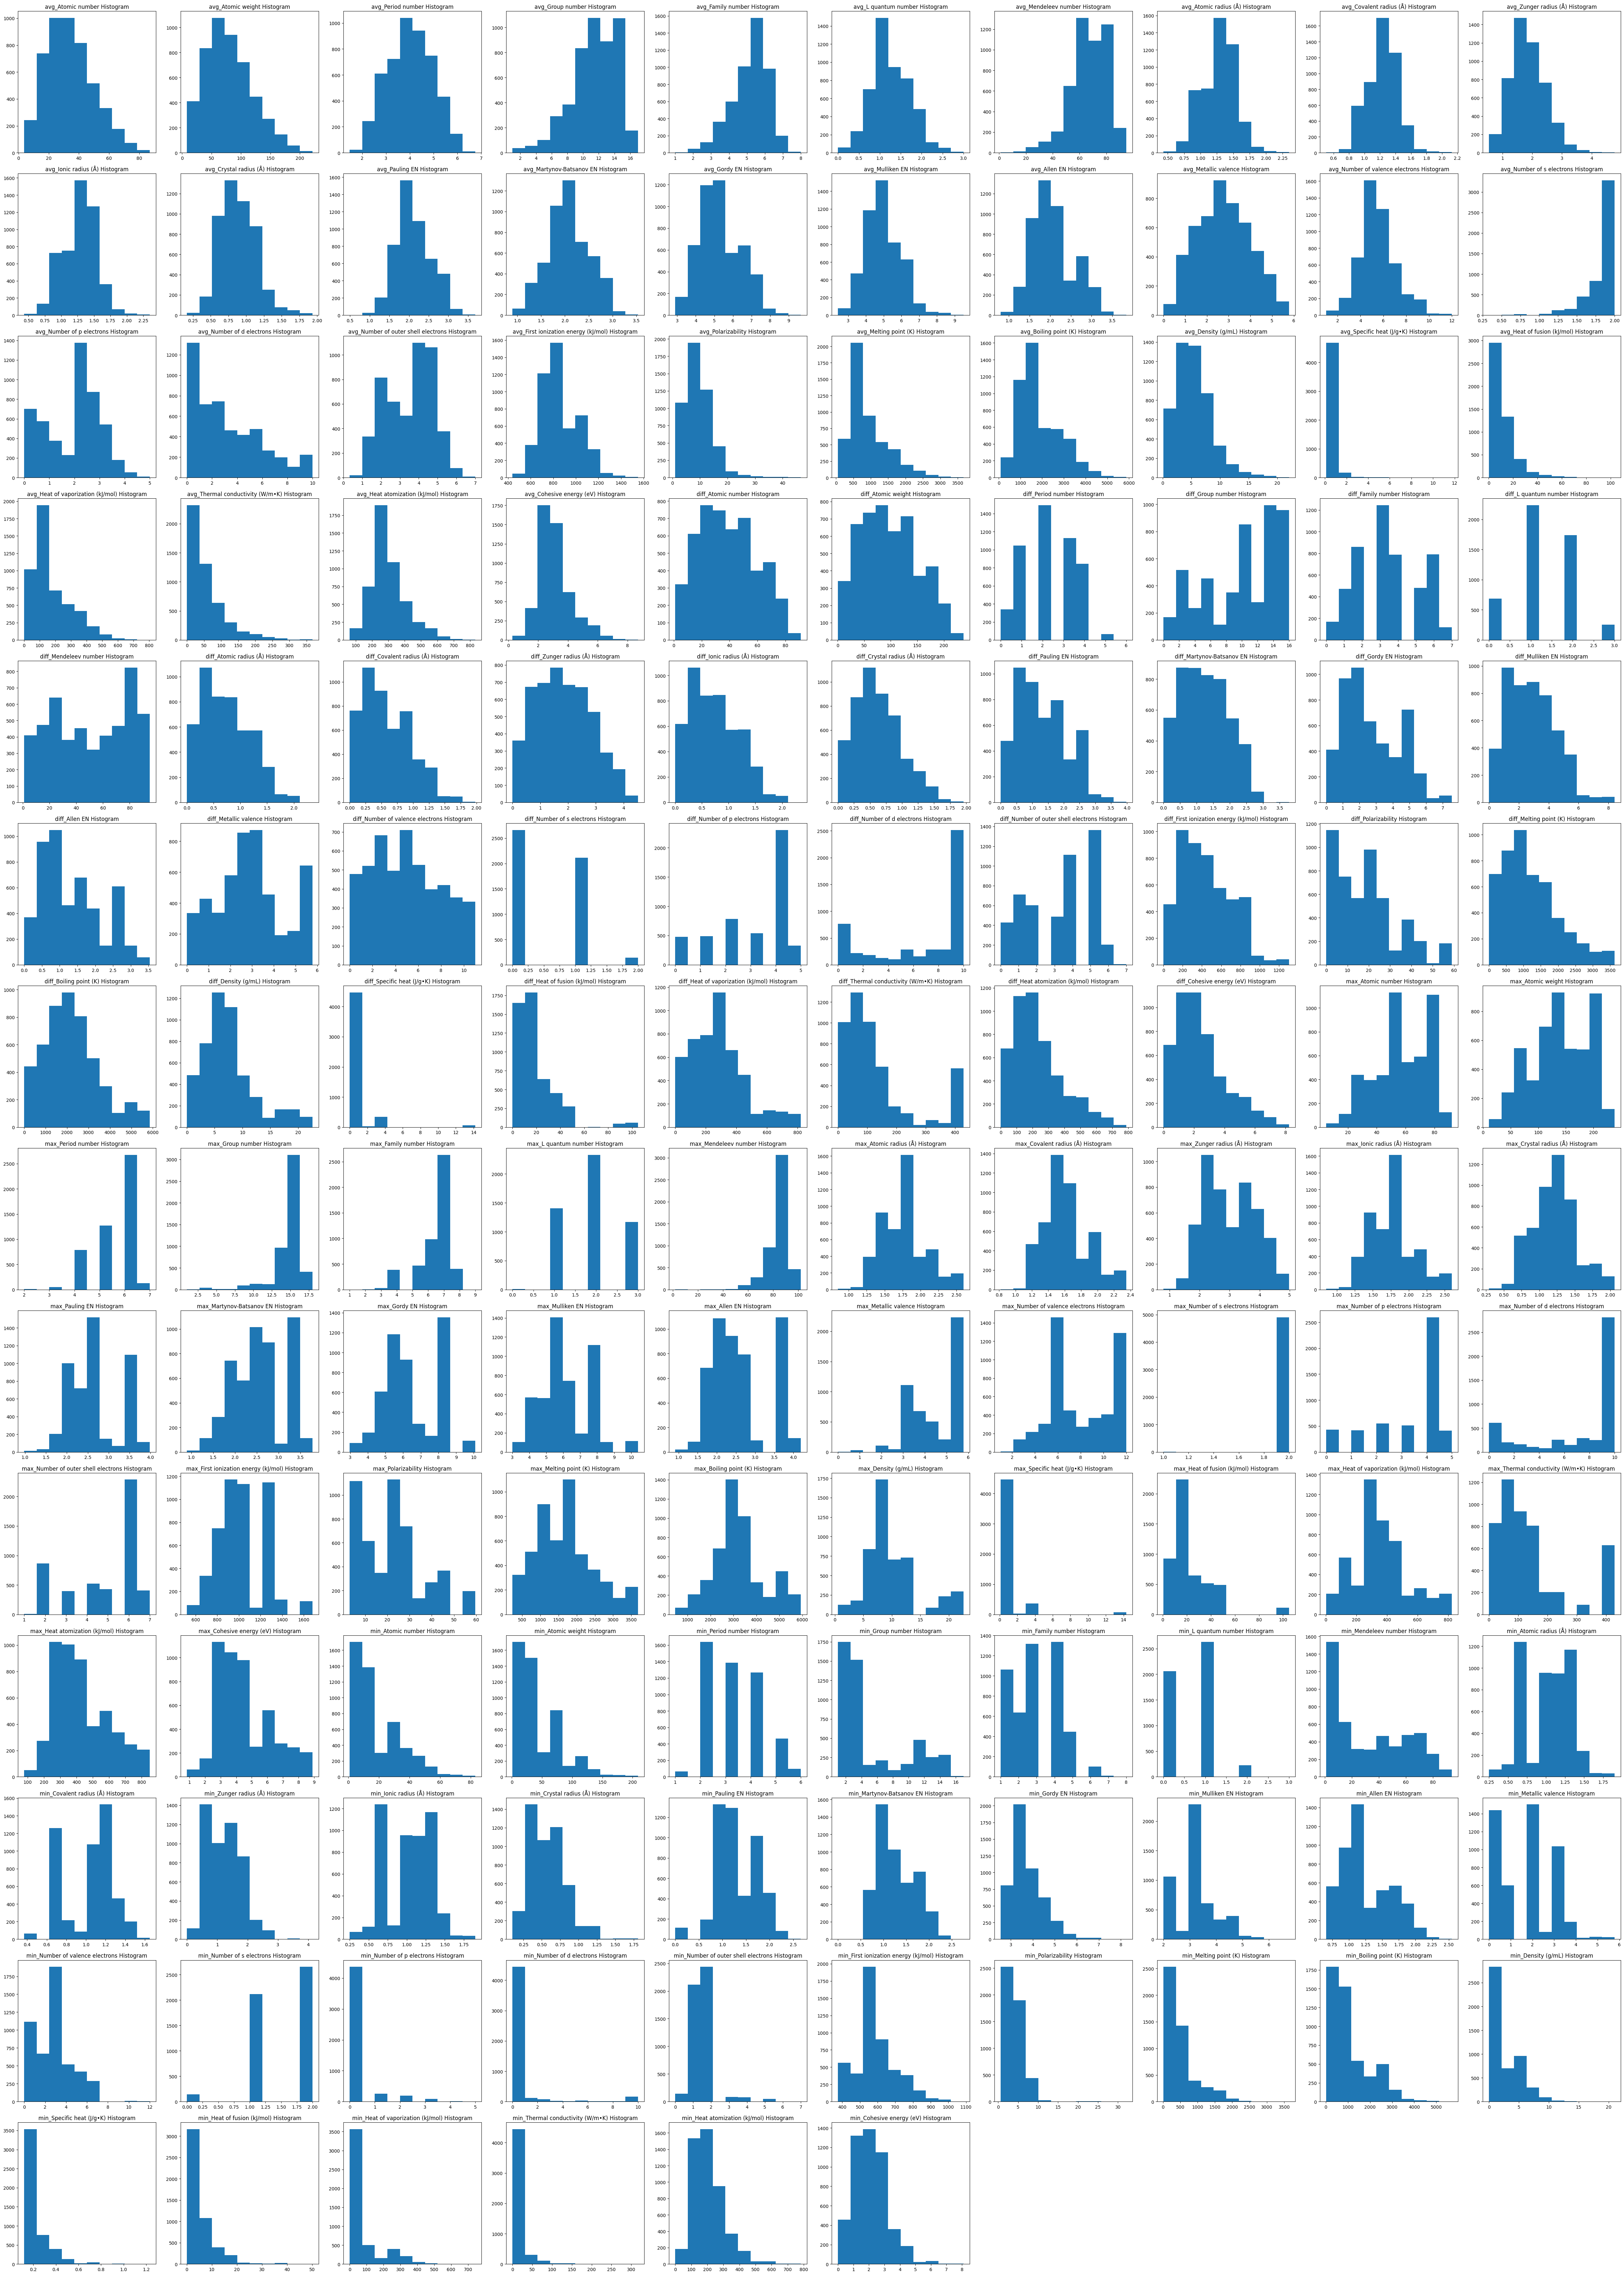

In [20]:
plot_variables(df=desc, vars_to_plot=cols, cts_vars=numerical_cols, num_cols=10, hist_num_bins=10)

### Preprocessing

In [21]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
    ])

preprocessor = ColumnTransformer(
    transformers=[('numeric', numeric_transformer, numerical_cols)],
    remainder='passthrough'
)

pipeline = Pipeline(steps=[('preprocessor', preprocessor)])
data = pipeline.fit_transform(desc)

In [22]:
dataframe = pd.DataFrame(data, columns=cols, index=df.index)

## ML Models Regression

### Setup

In [23]:
X_train, X_test, y_train, y_test = train_test_split(dataframe, df["Eg"], test_size=0.3, random_state=42)

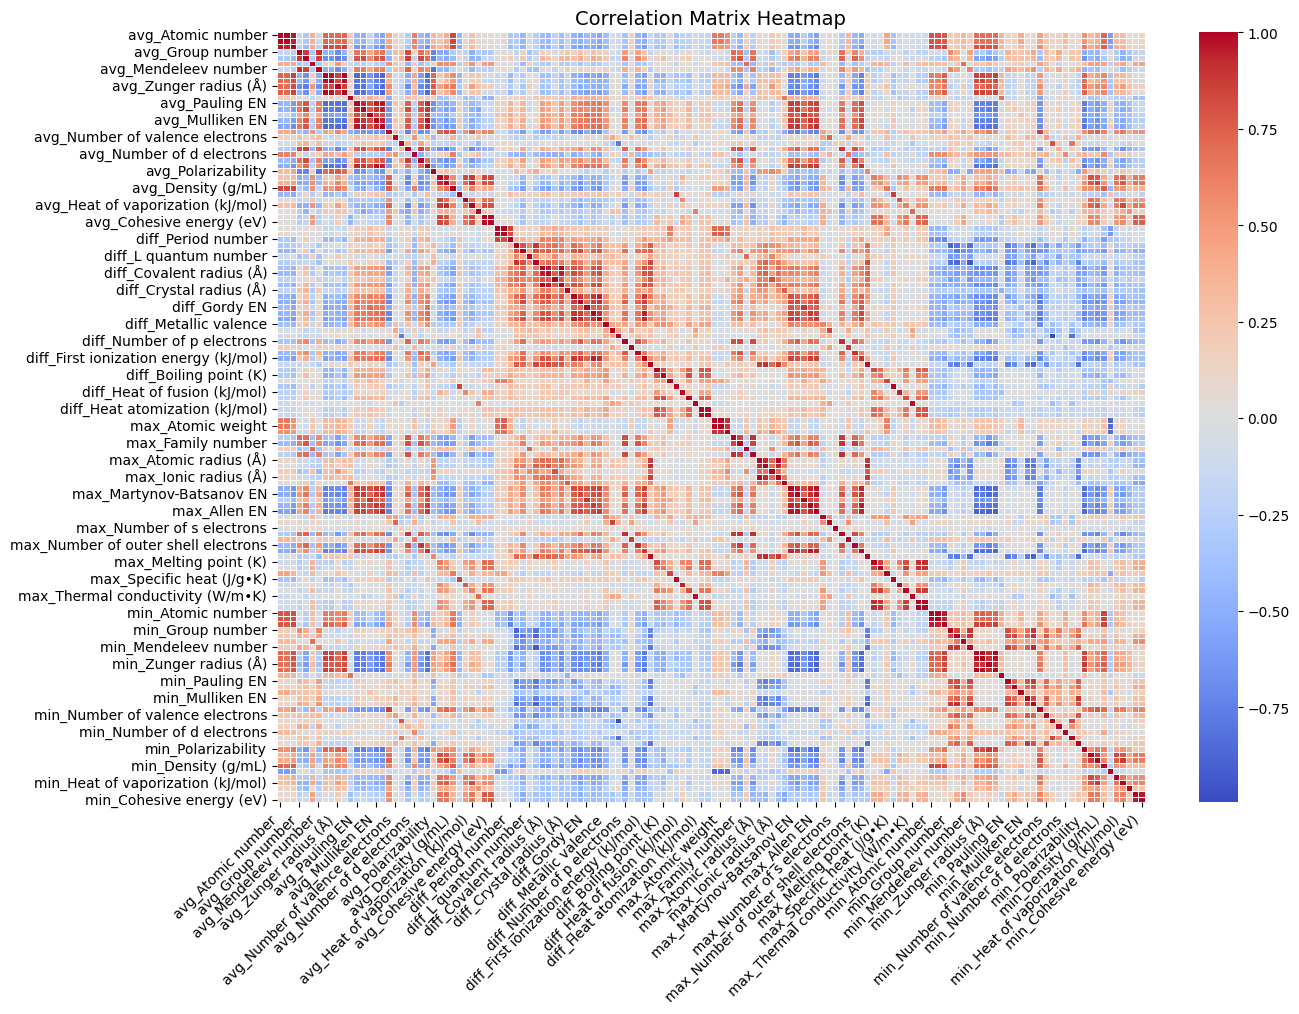

In [24]:
corr_matrix = X_train.corr()

plt.figure(figsize=(14, 10))
sns.heatmap(
    corr_matrix,
    annot=False,
    cmap="coolwarm",
    fmt=".2f",
    linewidths=0.5,
    annot_kws={"size": 8},
    )
plt.title("Correlation Matrix Heatmap", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.show()

In [25]:
r_squared_threshold = 0.95
r_squared = corr_matrix ** 2
mask = np.triu(np.ones(r_squared.shape), k=1).astype(bool)
r_squared_triu = r_squared.where(mask)
drop_cols = [col for col in r_squared_triu.columns if any(r_squared_triu[col] > r_squared_threshold)]
X_train = X_train.drop(drop_cols, axis=1)
X_test = X_test.drop(drop_cols, axis=1)
print(f"Columns dropped due to high correlation: {drop_cols}")

Columns dropped due to high correlation: ['avg_Atomic weight', 'avg_Ionic radius (Å)', 'avg_Cohesive energy (eV)', 'diff_Atomic weight', 'diff_Ionic radius (Å)', 'diff_Cohesive energy (eV)', 'max_Atomic weight', 'max_Ionic radius (Å)', 'max_Polarizability', 'max_Specific heat (J/g•K)', 'max_Thermal conductivity (W/m•K)', 'max_Cohesive energy (eV)', 'min_Atomic weight', 'min_Covalent radius (Å)', 'min_Ionic radius (Å)', 'min_Number of s electrons']


In [26]:
def eval_reg_model(X_data, X_test, y_data, y_test, model):
    model.fit(X_data, y_data)
    pred = model.predict(X_test)
    rmse = mean_squared_error(y_test, pred, squared=False)
    mae = mean_absolute_error(y_test, pred)
    r2 = r2_score(y_test, pred)
    model_name = type(model).__name__
    print("model: {},  rmse = {:.2f}, mae = {:.2f}, r2 = {:.2f}".format(model_name, rmse, mae, r2))

### Linear, Decision Tree, Support Vector, and Random Forest

In [27]:
eval_reg_model(X_train, X_test, y_train, y_test, LinearRegression())
eval_reg_model(X_train, X_test, y_train, y_test, DecisionTreeRegressor())
eval_reg_model(X_train, X_test, y_train, y_test, SVR(kernel="rbf"))
eval_reg_model(X_train, X_test, y_train, y_test, RandomForestRegressor())

model: LinearRegression,  rmse = 1.08, mae = 0.76, r2 = 0.43
model: DecisionTreeRegressor,  rmse = 1.14, mae = 0.55, r2 = 0.37
model: SVR,  rmse = 0.94, mae = 0.53, r2 = 0.57
model: RandomForestRegressor,  rmse = 0.81, mae = 0.45, r2 = 0.68


### Random Forest with GridSearchCV

In [28]:
%%time
search_space = {
   "n_estimators": [100, 200, 300],
   "max_features": [80, 90, 100],
   "max_depth": [7, 10, 14]
    }
forest_reg = RandomForestRegressor(random_state=0)
grid_search = GridSearchCV(estimator=forest_reg, param_grid=search_space,
                           cv=5, scoring="r2", return_train_score=True)
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)
print(grid_search.best_score_)
eval_reg_model(X_train, X_test, y_train, y_test, grid_search.best_estimator_)

{'max_depth': 14, 'max_features': 80, 'n_estimators': 100}
0.6763043018195048
model: RandomForestRegressor,  rmse = 0.82, mae = 0.46, r2 = 0.67
CPU times: user 6min 54s, sys: 1.63 s, total: 6min 56s
Wall time: 7min 3s


Cross-validation Average R2: 0.6194958685695551


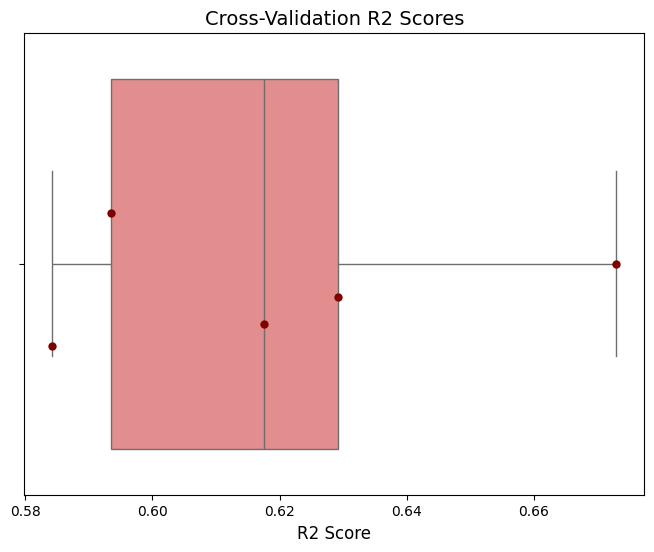

In [29]:
scores = cross_val_score(grid_search.best_estimator_, X_test, y_test, cv=5, scoring='r2')

print("Cross-validation Average R2:", scores.mean())

plt.figure(figsize=(8, 6))
sns.boxplot(x=scores, color='lightcoral')
sns.stripplot(x=scores, color='maroon', size=6, jitter=0.2)
plt.title('Cross-Validation R2 Scores', fontsize=14)
plt.xlabel('R2 Score', fontsize=12)
plt.show()

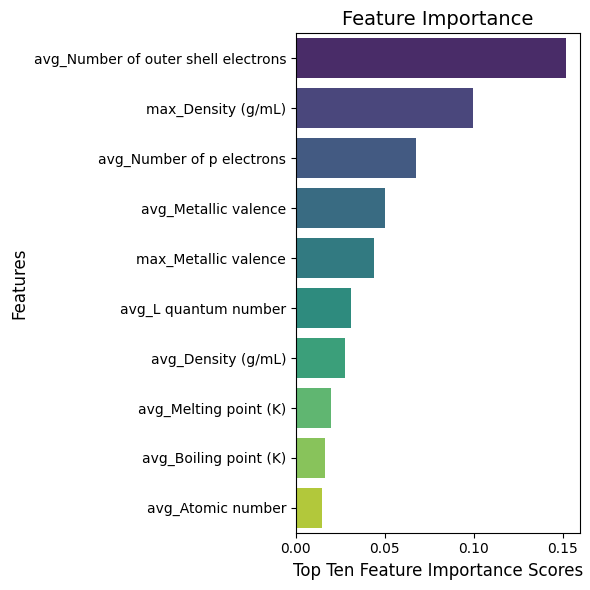

In [30]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_imp = pd.Series(feature_importances, index=X_train.columns).sort_values(ascending=False)

plt.figure(figsize=(6, 6))
sns.barplot(x=feature_imp[:10], y=feature_imp.index[:10], palette="viridis")
plt.xlabel("Top Ten Feature Importance Scores", fontsize=12)
plt.ylabel("Features", fontsize=12)
plt.title("Feature Importance", fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

In [31]:
explainer = shap.Explainer(grid_search.best_estimator_)
shap_values = explainer(X_test)

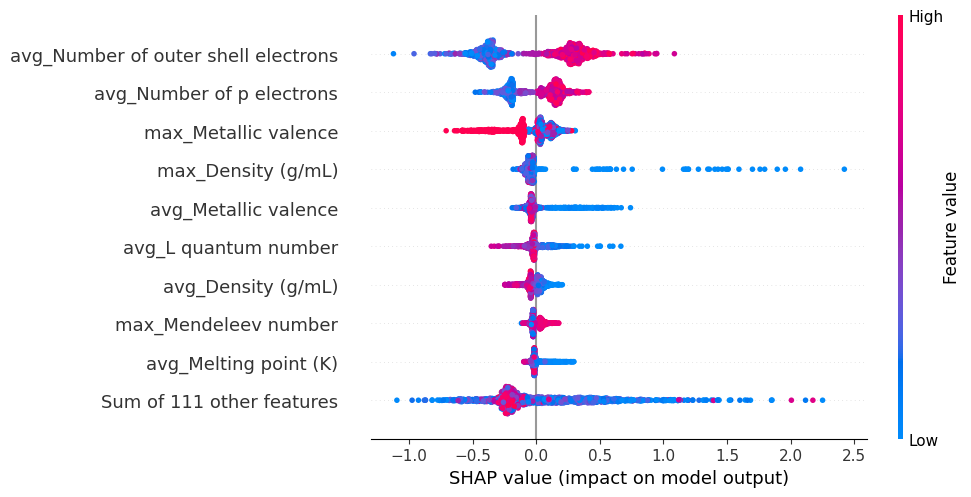

In [32]:
shap.plots.beeswarm(shap_values)

In [33]:
y_pred = grid_search.best_estimator_.predict(X_test)

metrics = {
    "MSE": mean_squared_error(y_test, y_pred),
    "RMSE": mean_squared_error(y_test, y_pred, squared=False),
    "MAE": mean_absolute_error(y_test, y_pred),
    "R²": r2_score(y_test, y_pred)
    }

for metric_name, metric_value in metrics.items():
    print(f"{metric_name}: {metric_value:.4f}")

MSE: 0.6677
RMSE: 0.8171
MAE: 0.4580
R²: 0.6739


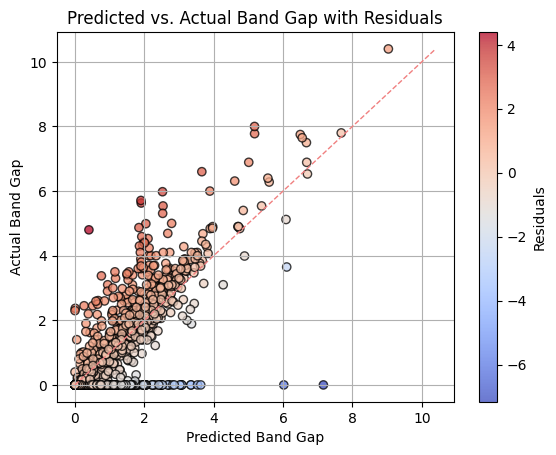

In [34]:
residuals = y_test.to_numpy().flatten() - y_pred
min_val = min(min(y_pred), min(y_test))
max_val = max(max(y_pred), max(y_test))

plt.scatter(y_pred, y_test, c=residuals, cmap='coolwarm', edgecolor='k', alpha=0.75)
plt.plot([min_val, max_val], [min_val, max_val], color='lightcoral', linestyle='--', linewidth=1)

plt.colorbar(label='Residuals')
plt.xlabel("Predicted Band Gap")
plt.ylabel("Actual Band Gap")
plt.title("Predicted vs. Actual Band Gap with Residuals")
plt.grid(True)
plt.show()

### Bagging, Random Forest, Extra Trees, AdaBoost, Gradient Boosting, and Hist Gradient Boosting

In [35]:
model_list = [
    (BaggingRegressor(estimator= Ridge(), n_estimators=100, random_state=42), "BaggingRegressor"),
    (RandomForestRegressor(random_state=42), "RandomForestRegressor"),
    (ExtraTreesRegressor(random_state=42), "ExtraTreesRegressor"),
    (AdaBoostRegressor(random_state=42), "AdaBoostRegressor"),
    (GradientBoostingRegressor(random_state=42), "GradientBoostingRegressor"),
    (HistGradientBoostingRegressor(random_state=42), "HistGradientBoostingRegressor")
    ]

In [36]:
def fit_model(regressor):

    if hasattr(regressor, 'early_stopping_rounds'):
        regressor.fit(
            X_train, y_train,
            eval_set=[(X_test, y_test)],
            early_stopping_rounds=10,
            eval_metric='rmse',
            verbose=False
            )
    else:
        regressor.fit(X_train, y_train)

    y_pred = regressor.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    return mse, mae, r2

results = []
for reg, name in model_list:
    mse, mae, r2 = fit_model(reg)
    results.append({
        "Model": name,
        "MSE": mse,
        "MAE": mae,
        "R²": r2
        })

pd.DataFrame(results)

Model       MSE       MAE        R²
0               BaggingRegressor  1.173154  0.775497  0.427072
1          RandomForestRegressor  0.678303  0.453841  0.668740
2            ExtraTreesRegressor  0.609531  0.419136  0.702326
3              AdaBoostRegressor  1.877852  1.213406  0.082921
4      GradientBoostingRegressor  0.717962  0.524139  0.649372
5  HistGradientBoostingRegressor  0.583703  0.434160  0.714939

Stacking Regressor

In [37]:
%%time
estimators = [
    ('ridge', Ridge()),
    ('linear', LinearRegression()),
    ('knr', KNeighborsRegressor())
    ]

final_estimator = HistGradientBoostingRegressor()
stacking_reg = StackingRegressor(estimators=estimators, final_estimator=final_estimator)

param_grid = {
    'ridge__alpha': [0.1, 1.0, 10.0],
    'knr__n_neighbors': [3, 5, 7],
    'final_estimator__max_bins': [40, 50, 60],
    'final_estimator__learning_rate': [0.01, 0.1, 0.2]
    }


grid_search = GridSearchCV(estimator=stacking_reg, param_grid=param_grid, cv=5,
                           scoring='neg_mean_squared_error', verbose=1)
grid_search.fit(X_train, y_train)
model = grid_search.best_estimator_
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("MSE:", mse)
print("R²:", r2)
print("Best Parameters:", grid_search.best_params_)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
MSE: 0.9057539586981713
R²: 0.5576606756613616
Best Parameters: {'final_estimator__learning_rate': 0.1, 'final_estimator__max_bins': 40, 'knr__n_neighbors': 3, 'ridge__alpha': 1.0}
CPU times: user 3min 14s, sys: 3.79 s, total: 3min 18s
Wall time: 3min 19s


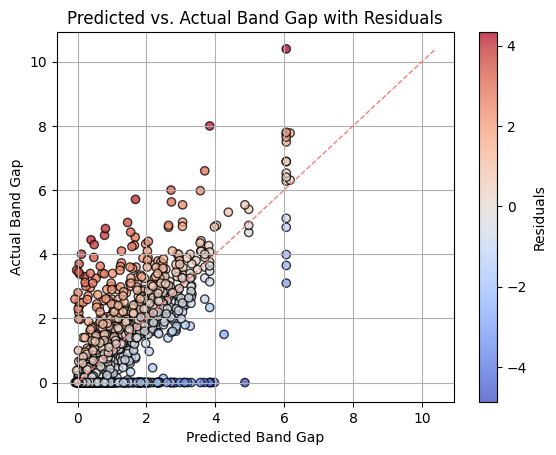

In [38]:
residuals = y_test.to_numpy().flatten() - y_pred
min_val = min(min(y_pred), min(y_test))
max_val = max(max(y_pred), max(y_test))

plt.scatter(y_pred, y_test, c=residuals, cmap='coolwarm', edgecolor='k', alpha=0.75)
plt.plot([min_val, max_val], [min_val, max_val], color='lightcoral', linestyle='--', linewidth=1)

plt.colorbar(label='Residuals')
plt.xlabel("Predicted Band Gap")
plt.ylabel("Actual Band Gap")
plt.title("Predicted vs. Actual Band Gap with Residuals")
plt.grid(True)
plt.show()

### XGBoost

In [39]:
%%time
param_grid = {
              "max_depth": [8, 10],
              "reg_lambda": [5.0, 7.0],
              "colsample_bytree": [0.6, 0.7],
              "colsample_bylevel": [0.6, 0.7],
              "colsample_bynode": [0.75, 0.8, 0.85],
              }



grid_search = GridSearchCV(estimator = xgb.XGBRegressor(objective="reg:squarederror",
                                                        seed=42,
                                                        subsample=0.7,
                                                        early_stopping_rounds=20,
                                                        ),
                           param_grid=param_grid,
                           scoring="neg_root_mean_squared_error",
                           verbose=0,
                           n_jobs=4,
                           cv=2)

grid_search.fit(X_train,
                y_train,
                verbose=False,
                eval_set=[(X_test, y_test)]
                )

CPU times: user 11.9 s, sys: 461 ms, total: 12.4 s
Wall time: 2min 8s


GridSearchCV(cv=2,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=20,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             n_jobs=4,
             param_grid={'colsample_bylevel': [0.6, 0.7],
                         'colsample_bynode': [0.75, 0.8, 0.85],
                         'colsample_bytree': [0.6, 0.7], 'max_depth': [8, 10],
                         'reg_lambda': [5.0, 7.0]},
             scoring='neg_root_mean_squared_error')

In [40]:
print(grid_search.best_params_)

{'colsample_bylevel': 0.7, 'colsample_bynode': 0.8, 'colsample_bytree': 0.7, 'max_depth': 10, 'reg_lambda': 5.0}


In [41]:
y_pred = grid_search.best_estimator_.predict(X_test)

In [42]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R-squared (R2 Score): {r2:.4f}")

Mean Squared Error (MSE): 0.6659
R-squared (R2 Score): 0.6748


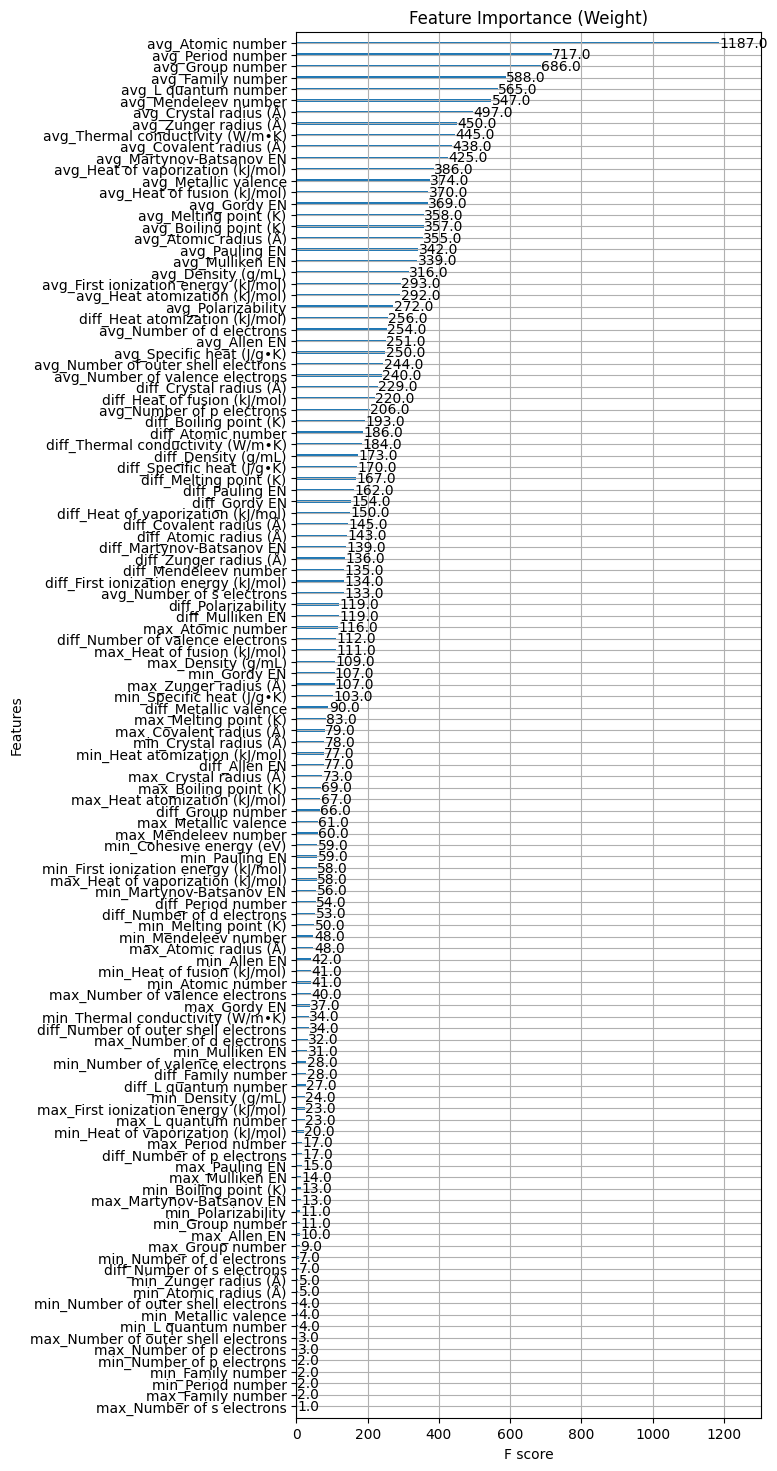

In [43]:
fig, ax = plt.subplots(figsize=(6, 18))
xgb.plot_importance(grid_search.best_estimator_, importance_type='weight', height=0.2, ax=ax)
plt.ylabel('Features')
plt.title('Feature Importance (Weight)')
plt.show()

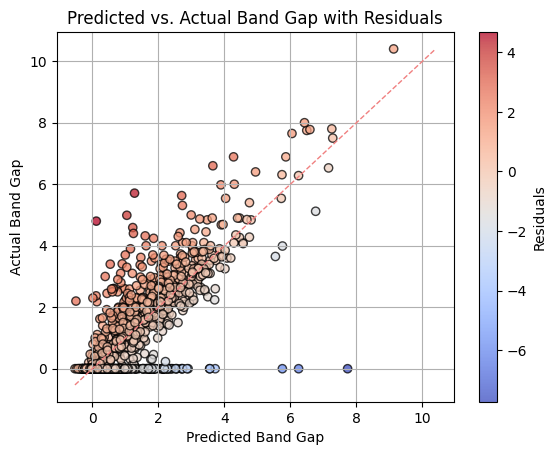

In [44]:
residuals = y_test.to_numpy().flatten() - y_pred
min_val = min(min(y_pred), min(y_test))
max_val = max(max(y_pred), max(y_test))

plt.scatter(y_pred, y_test, c=residuals, cmap='coolwarm', edgecolor='k', alpha=0.75)
plt.plot([min_val, max_val], [min_val, max_val], color='lightcoral', linestyle='--', linewidth=1)

plt.colorbar(label='Residuals')
plt.xlabel("Predicted Band Gap")
plt.ylabel("Actual Band Gap")
plt.title("Predicted vs. Actual Band Gap with Residuals")
plt.grid(True)
plt.show()

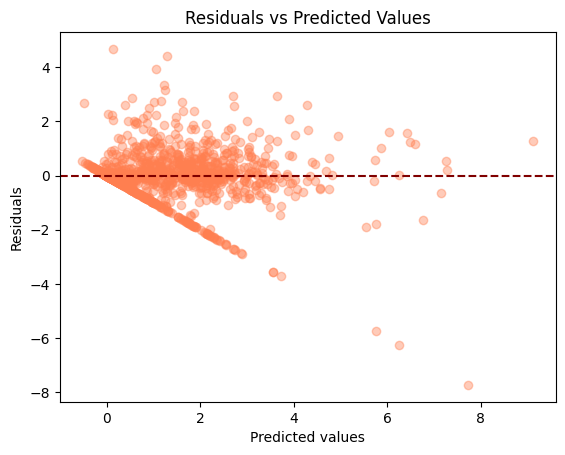

In [45]:
plt.figure()
plt.scatter(y_pred, residuals, color="coral", alpha=0.4)
plt.axhline(y=0, color='maroon', linestyle='--')
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted Values")
plt.show()

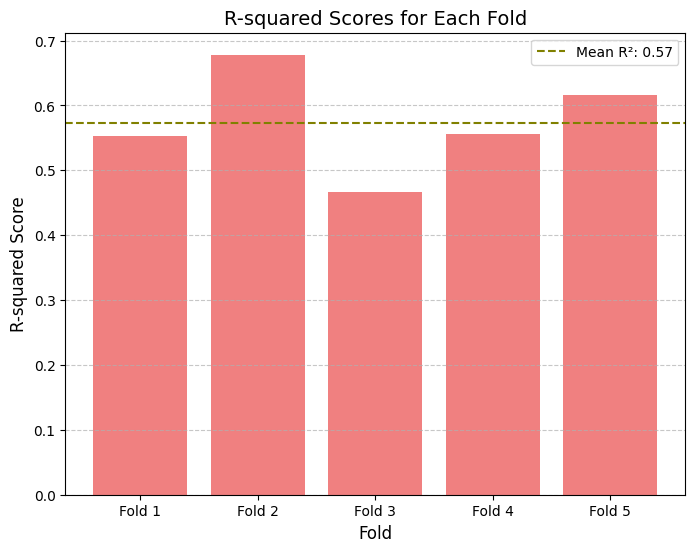

Mean R2 score: 0.5737109635063635


In [46]:
kfolds = KFold(n_splits=5, shuffle=True, random_state=42)

r2_scores = []

for xt_index, xv_index in kfolds.split(X_test):
    Xt_fold, Xv_fold = X_test.iloc[xt_index], X_test.iloc[xv_index]
    yt_fold, yv_fold = y_test.iloc[xt_index], y_test.iloc[xv_index]

    best_estimator = grid_search.best_estimator_
    best_estimator.fit(Xt_fold, yt_fold,
                       eval_set=[(Xv_fold, yv_fold)],
                       verbose=False)

    pred = best_estimator.predict(Xv_fold)
    r2 = r2_score(yv_fold, pred)
    r2_scores.append(r2)

plt.figure(figsize=(8, 6))
plt.bar(np.arange(len(r2_scores)), r2_scores, color='lightcoral')
plt.axhline(y=np.mean(r2_scores), color='olive', linestyle='--', label=f'Mean R²: {np.mean(r2_scores):.2f}')
plt.xlabel('Fold', fontsize=12)
plt.ylabel('R-squared Score', fontsize=12)
plt.title('R-squared Scores for Each Fold', fontsize=14)
plt.xticks(np.arange(len(r2_scores)), [f'Fold {i+1}' for i in range(len(r2_scores))])
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.show()
print(f"Mean R2 score: {np.mean(r2_scores)}")

### LightGBM

In [47]:
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

In [48]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'l2',
    'max_depth': -1,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
    }

param_dist = {
    'num_leaves': [7, 13, 17, 20],
    'learning_rate': [0.05, 0.1, 0.2],
    'n_estimators': [200, 500, 700]
    }

In [49]:
%%time
lgb_estimator = lgb.LGBMRegressor(**params)

random_search = RandomizedSearchCV(estimator=lgb_estimator,
                                   param_distributions=param_dist,
                                   n_iter=50,
                                   cv=5,
                                   n_jobs=-1)

random_search.fit(X_train, y_train)

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
CPU times: user 4.49 s, sys: 330 ms, total: 4.82 s
Wall time: 4min 23s


RandomizedSearchCV(cv=5,
                   estimator=LGBMRegressor(bagging_fraction=0.8, bagging_freq=5,
                                           feature_fraction=0.9, metric='l2',
                                           objective='regression', verbose=0),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'learning_rate': [0.05, 0.1, 0.2],
                                        'n_estimators': [200, 500, 700],
                                        'num_leaves': [7, 13, 17, 20]})

In [50]:
print("Best hyperparameters: ", random_search.best_params_)

Best hyperparameters:  {'num_leaves': 13, 'n_estimators': 700, 'learning_rate': 0.05}


In [51]:
y_pred = random_search.best_estimator_.predict(X_test)

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


In [52]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R-squared (R2 Score): {r2:.4f}")

Mean Squared Error (MSE): 0.5693
R-squared (R2 Score): 0.7220


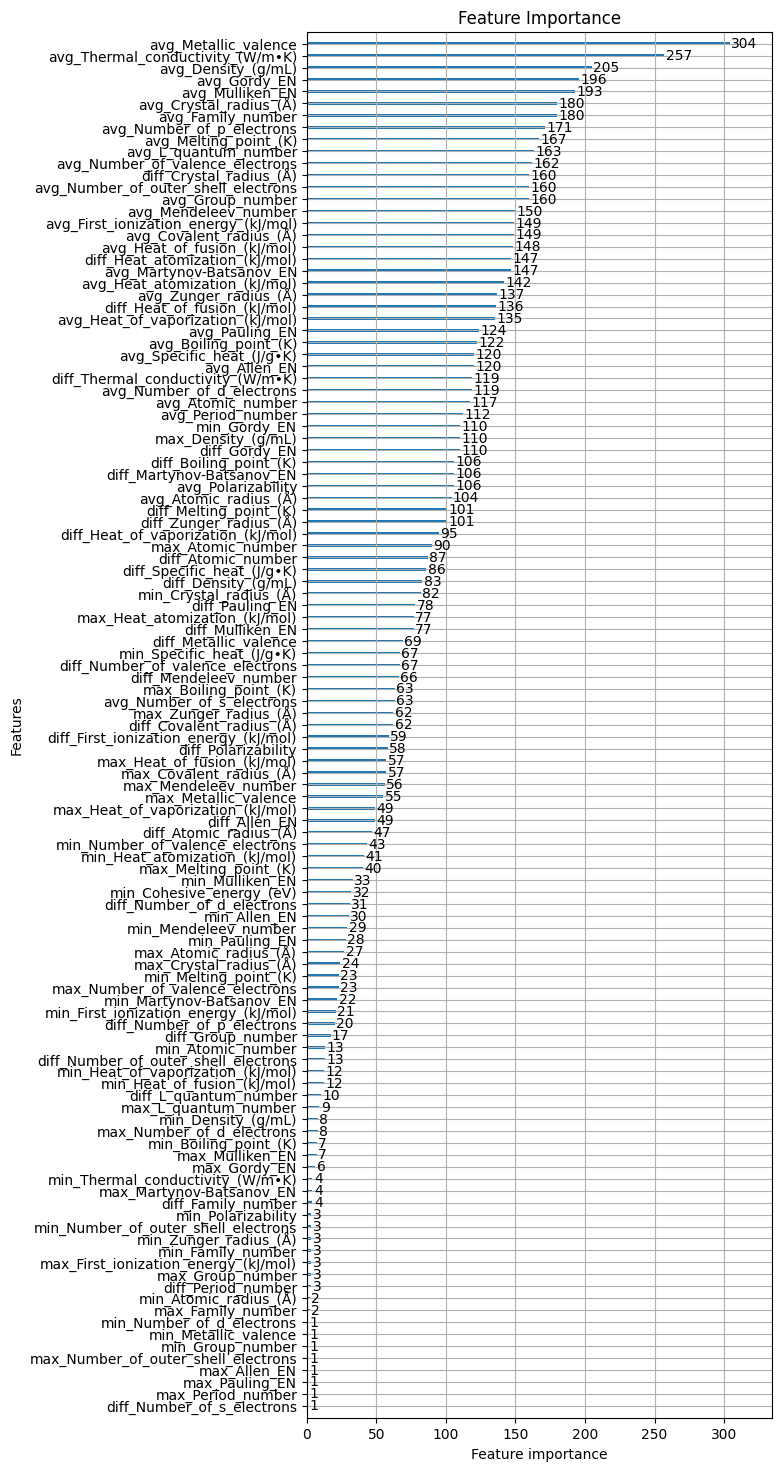

In [53]:
fig, ax = plt.subplots(figsize=(6, 18))
lgb.plot_importance(random_search.best_estimator_, height=0.2, ax=ax)
plt.ylabel('Features')
plt.title('Feature Importance')
plt.show()

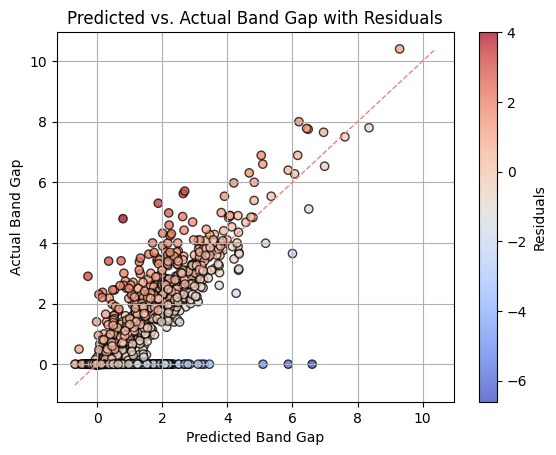

In [54]:
residuals = y_test.to_numpy().flatten() - y_pred
min_val = min(min(y_pred), min(y_test))
max_val = max(max(y_pred), max(y_test))

plt.scatter(y_pred, y_test, c=residuals, cmap='coolwarm', edgecolor='k', alpha=0.75)
plt.plot([min_val, max_val], [min_val, max_val], color='lightcoral', linestyle='--', linewidth=1)

plt.colorbar(label='Residuals')
plt.xlabel("Predicted Band Gap")
plt.ylabel("Actual Band Gap")
plt.title("Predicted vs. Actual Band Gap with Residuals")
plt.grid(True)
plt.show()

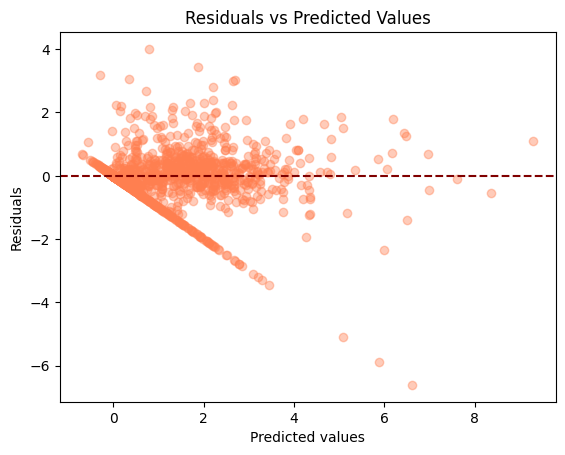

In [55]:
plt.figure()
plt.scatter(y_pred, residuals, color="coral", alpha=0.4)
plt.axhline(y=0, color='maroon', linestyle='--')
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted Values")
plt.show()

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: ba

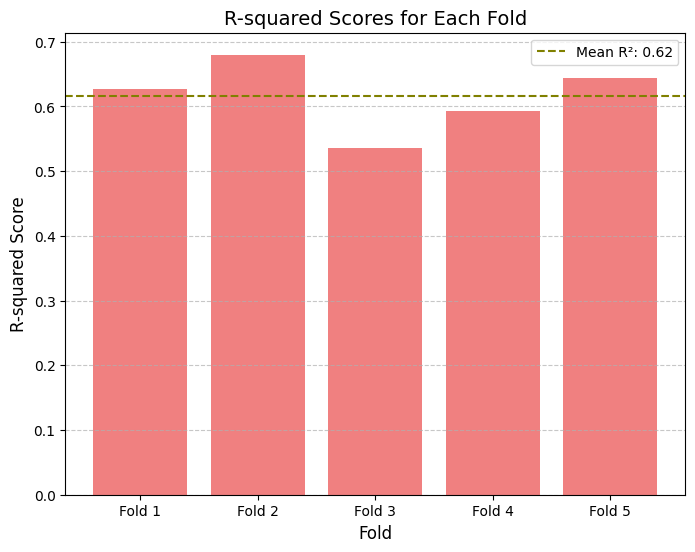

Mean R2 score: 0.6162182390584137


In [56]:
kfolds = KFold(n_splits=5, shuffle=True, random_state=42)

r2_scores = []

for xt_index, xv_index in kfolds.split(X_test):
    Xt_fold, Xv_fold = X_test.iloc[xt_index], X_test.iloc[xv_index]
    yt_fold, yv_fold = y_test.iloc[xt_index], y_test.iloc[xv_index]

    best_estimator = random_search.best_estimator_
    best_estimator.fit(Xt_fold, yt_fold,
                       eval_set=[(Xv_fold, yv_fold)])

    pred = best_estimator.predict(Xv_fold)
    r2 = r2_score(yv_fold, pred)
    r2_scores.append(r2)

plt.figure(figsize=(8, 6))
plt.bar(np.arange(len(r2_scores)), r2_scores, color='lightcoral')
plt.axhline(y=np.mean(r2_scores), color='olive', linestyle='--', label=f'Mean R²: {np.mean(r2_scores):.2f}')
plt.xlabel('Fold', fontsize=12)
plt.ylabel('R-squared Score', fontsize=12)
plt.title('R-squared Scores for Each Fold', fontsize=14)
plt.xticks(np.arange(len(r2_scores)), [f'Fold {i+1}' for i in range(len(r2_scores))])
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.show()
print(f"Mean R2 score: {np.mean(r2_scores)}")